<a href="https://colab.research.google.com/github/CristhianSeverino/Afiliados360/blob/En-Proceso/EDA_360_Afiliados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA 360 Afiliados**

> Este es uno de los sprint's. Detallados en el *Road Map* de 360 Afiliados. Recomiendo visitar el repositorio para mayor contexto.

* Repositorio: https://github.com/CristhianSeverino/Afiliados360.git



**Objetivos:**

* Analisis Exploratorio de Datos.
* Consumo de Datos desde el buckect. alimentado en un sprint anterior.
* Feature Engineering/Ingenieria de Caracteristicas.
* Data set Transformado para BI con Insigths Estrategicos.
* Alimentacion del Bukect De data transformada. con el data set.


**Proximos Pasos:**
* Data Sciencie.
* RAG
* BI Startegic



> Este Notebook es creacion de: **Cristhian Calle Severino**.


**Diveirtete Explorandolo ☕**

*   **Github**: https://github.com/CristhianSeverino
*   **Linkedin**: https://www.linkedin.com/in/cristhianandrescalleseverino/


# **Instalar e Importar Librerias**

In [35]:
!pip install boto3
!pip install awscli
print("="*45+"   Librerias AWS Instaldas   "+"="*45)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import missingno as msno
import os
import boto3
from google.colab import userdata
import botocore.exceptions
import polars as pl
from datetime import datetime
import matplotlib.colors as mcolors
from IPython.display import display
print("="*45+"   Librerias Importadas  "+"="*45)

=============================================   Librerias AWS Instaldas   =============================================
=============================================   Librerias Importadas  =============================================


# **Importar Datos del Bucket**

> Traer el Dataset del proceso ELT, Es decir el primer bucket sin trasnformar para hacer ingenieria de caracteristicas.💾



In [36]:
#==========================================   1. Fucion de Configuracion AWS   ============================================

def configure_aws_credentials():
    try:
        aws_access_key_id =userdata.get('AWS_ACCESS_KEY_ID')
        aws_secret_access_key = userdata.get('AWS_SECRET_ACCESS_KEY')
        region_name = userdata.get('AWS_REGION')
        #Verificar las credenciales
        if not all([aws_access_key_id, aws_secret_access_key, region_name]):
            raise ValueError("Falta Cargar las Crredeciales en Secrets ;)")

        # Crear Archivos de configuracion de AWS.
        aws_dir ='/root/.aws'
        os.makedirs(aws_dir, exist_ok=True)

        #Escribir el Archivo 'credentials'

        with open(os.path.join(aws_dir, 'credentials'),'w') as f:
            f.write(f'[default]\n')
            f.write(f'aws_access_key_id = {aws_access_key_id}\n')
            f.write(f'aws_secret_access_key ={aws_secret_access_key}\n')

        #Escribir el Archivo 'config'

        with open(os.path.join(aws_dir, 'config'), 'w') as f:
            f.write(f'[default]\n')
            f.write(f'region = {region_name}\n')

        print("="*17+"   Archivos de configuracion de AWS creados Exitosamente   "+"="*17)
        return True

    except Exception as e:
        print (f"Error al connfigurar las credenciales de AWS, Observa: {str(e)}")
        return False

#=====================================   2. Función de Descarga del Bucket ELT   ======================================

def download_from_s3(bucket_name, s3_file_path, local_file_path):
    try:
        #Configuurar cliente S3
        s3_client = boto3.client('s3')

        #crear el directorio local
        local_dir = os.path.dirname(local_file_path)
        if local_dir:
            os.makedirs(local_dir, exist_ok=True)

        #Descargar el Archivo desde S3
        s3_client.download_file(bucket_name, s3_file_path, local_file_path)
        print(f"Archivo Descargado Con ¡Exito!: {local_file_path}")
        return True

    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code']== "404":
            print(f"El archivo {s3_file_path} no existe en el buket {bucket_name}. VERIFICA LOS NOMBRES")
        else:
            print(f"Error al descargar el archivo desde S3: {str(e)}")
            return False

    except Exception as e:
        print(f"Error inesperado: {str(e)}")
        return False


In [37]:
#=========================   Inicializacion de las funciones de optencion de los datasets   ==========================

if __name__ == "__main__":
  #Cofigurar Credeciales
  if configure_aws_credentials():

    bucket_name = "vision-360-afiliados"

    files_download = [
        ("landing-zone/servicios_usados/servicios_usados.csv", "/content/servicios_usados.csv"),
        ("landing-zone/subsidios_otorgados/subsidios_otorgados.csv", "/content/subsidios_otorgados.csv"),
        ("landing-zone/usuarios2024/usuarios2024.csv", "/content/usuarios2024.csv")
    ]

    for s3_file_path, local_file_path in files_download:
        print(f"Descargando {s3_file_path} a {local_file_path}...")
        success = download_from_s3(bucket_name, s3_file_path, local_file_path)
        if not success:
            print(f"No se Pudo descargar {s3_file_path}")

=================   Archivos de configuracion de AWS creados Exitosamente   =================
Descargando landing-zone/servicios_usados/servicios_usados.csv a /content/servicios_usados.csv...
Archivo Descargado Con ¡Exito!: /content/servicios_usados.csv
Descargando landing-zone/subsidios_otorgados/subsidios_otorgados.csv a /content/subsidios_otorgados.csv...
Archivo Descargado Con ¡Exito!: /content/subsidios_otorgados.csv
Descargando landing-zone/usuarios2024/usuarios2024.csv a /content/usuarios2024.csv...
Archivo Descargado Con ¡Exito!: /content/usuarios2024.csv


*Verifica en la barra lateral izquierda si los archivos se han descargado ✒*

# Limpieza del Data Set con **Pandas**

In [38]:
#1.=========================================   Cargar y Analizar datos   =====================================

def cargar_analizardf(ruta_csv, nombre_df="DataFrame"):
    try:
      df = pd.read_csv(ruta_csv)
      print(f"{'='*17}   Data Frame '{nombre_df}' Creado con Éxito   {'='*17}")
      print(df.head(5))
      print(f"{'='*17}   Estadísticas del DF '{nombre_df}   {'='*17}")
      print(df.describe())
      print(f"{'='*17}   Información del DF '{nombre_df}'   {'='*17}")
      df.info()
      print(f"{'='*17}   Valores Nulos del DF '{nombre_df}'   {'='*17}")
      print(df.isnull().sum())
      print("Porcentaje de nulos:\n", df.isnull().sum() / len(df))
      msno.matrix(df)
      plt.savefig('MissingMatriz_{nombre_df}.png')
      plt.close()
      print(f"{'='*17}   Matriz de Valores nulos de: '{nombre_df}' Guardada con exito   {'='*17}")
      return df
    except FileNotFoundError:
      print(f"Error: No se encontro el Archivo en la ruta: {ruta_csv}")
      return None
    except Exception as e:
      print(f"Ocurrio un error inesperado: {e}")
      return None





In [39]:
# Suponiendo que tienes tres archivos CSV en las siguientes rutas
# Rutas de los archivos CSV
ruta_usuarios = '/content/usuarios2024.csv'
ruta_servicios = '/content/servicios_usados.csv'
ruta_subsidios = '/content/subsidios_otorgados.csv'

#Cagar y Analizar Cada Data Frame
print("Analizando DataFrame de Usuarios:")
usuarios_df = cargar_analizardf(ruta_usuarios, nombre_df="usuarios_df")
print("\n" + "="*50)
print("Analizando DataFrame de Servicios:")
servicios_df = cargar_analizardf(ruta_servicios, nombre_df="servicios_df")
print("\n" + "="*50)
print("Analizando DataFrame de Subsidios:")
subsidios_df = cargar_analizardf(ruta_subsidios, nombre_df="subsidios_df")



# Verificar que los DataFrames no sean None antes de imprimir
print("\n" + "="*50)
print(" "*15 + "Imprimiendo Data Frames")
print("\n" + "="*50)



if usuarios_df is not None:
    print("Usuarios DataFrame no es un None")
    print(usuarios_df.head())
else: print("Error: usuarios_df es None")

if servicios_df is not None:
    print("Servicios DataFrame no es un None")
    print(servicios_df.head())
else:
    print("Error: servicios_df es None")

if subsidios_df is not None:
    print("Subsidios DataFrame no es None")
    print(subsidios_df.head())
else:
    print("Error: subsidios_df es None")




Analizando DataFrame de Usuarios:
=================   Data Frame 'usuarios_df' Creado con Éxito   =================
           id                          nombre categoria  \
0  1000083810            María Marcela Torres         C   
1  1000093850          David Fernández Montes         A   
2  1000005695  Sebastián Frank Rivera Caicedo         C   
3  1000048520         Alberto Fernando Cuesta         C   
4  1000052581                  Andrés Barreto         C   

                       correo  municipio fecha_nacimiento           telefono  
0  buitragostiven@example.org  Risaralda       1974-02-20         6094133890  
1     jhonherrera@example.org  La Dorada       2005-03-09    (+57)3111615594  
2        carlos10@example.net  La Merced       1994-07-04          331 64 75  
3    leoncarolina@example.net  La Merced       1959-02-23  +57 314 835 03 05  
4      fernanda76@example.net   Norcasia       1957-12-15  +57 607 638 84 96  
=================   Estadísticas del DF 'usuarios_df   

In [40]:
print(subsidios_df)
print(servicios_df)
print(usuarios_df)

                id                   tipo_subsidio            categoria  \
0       1000083810                 Cuota Monetaria   Subsidio Monetario   
1       1000093850                 Cuota Monetaria   Subsidio Monetario   
2       1000005695                 Cuota Monetaria   Subsidio Monetario   
3       1000048520  Alimentos Centros Vacacionales  Subsidio en Especie   
4       1000052581                 Cuota Monetaria   Subsidio Monetario   
...            ...                             ...                  ...   
149995  1000053054                 Cuota Monetaria   Subsidio Monetario   
149996  1000036901                 Cuota Monetaria   Subsidio Monetario   
149997  1000012942  Alimentos Centros Vacacionales  Subsidio en Especie   
149998  1000040993  Alimentos Centros Vacacionales  Subsidio en Especie   
149999  1000004879                 Cuota Monetaria   Subsidio Monetario   

        monto       fecha  
0       31785  2024-12-28  
1       50158  2024-04-08  
2       50699  

# **Igenieria de Caracteristicas**


> Con **pandas**

1. Caracteristcias de comportamieto de Afiliados
2. Caracteristicas y datsets para Ml y DL
3. Caracteristicas Estratgicas de alto nivel.

---




In [43]:
#=================================   Función Generar Caracteristicas Afiliados   ================================
def generar_caracteristicas_afiliados(usuarios_df, subsidios_df, servicios_df):
    print("="*45 + "   Iniciando Ingeniería de Características 1   " + "="*45)

    # Preparación de Datos
    try:
        usuarios_df = usuarios_df.copy()
        usuarios_df['fecha_nacimiento'] = pd.to_datetime(usuarios_df['fecha_nacimiento'])
        subsidios_df = subsidios_df.copy()
        subsidios_df['fecha'] = pd.to_datetime(subsidios_df['fecha'])
        servicios_df = servicios_df.copy()
        servicios_df['fecha'] = pd.to_datetime(servicios_df['fecha'])
    except KeyError as e:
        print(f"Error: No se encontró la columna requerida, revisa el nombre de la columna: {e}")
        return None
    except Exception as e:
        print(f"Ocurrió un error al convertir las fechas: {e}")
        return None

    fecha_actual = datetime.now()

    # Creación de Características:
    # 1. Edad del afiliado
    usuarios_df['edad_afiliado'] = np.floor((fecha_actual - usuarios_df['fecha_nacimiento']).dt.days / 365.25).astype(int)

    # 2. Antigüedad del afiliado
    usuarios_df['antiguedad_afiliado_años'] = (usuarios_df['edad_afiliado'] - 18).astype(int)
    recaudo_aprox = {'A': 61000, 'B': 156000, 'C': 320000}
    usuarios_df['recaudo_mensual'] = usuarios_df['categoria'].map(recaudo_aprox).fillna(0)
    usuarios_df['recaudo_anual'] = usuarios_df['recaudo_mensual'] * 12

    # 3. Cantidad de Subsidios y 4. Monto de Subsidios
    df_subsidios_agregado = subsidios_df.groupby('id').agg(
        cantidad_subsidios=('id', 'count'),
        monto_total_subsidios=('monto', 'sum')
    ).reset_index()

    # 5. Cantidad de Servicios y 6. Diversidad de servicios
    df_servicios_agregado = servicios_df.groupby('id').agg(
        cantidad_servicios=('id', 'count'),
        diversidad_servicios=('servicio', 'nunique')
    ).reset_index()

    # Unir las agregaciones a usuarios_df
    df_agregado = pd.merge(df_subsidios_agregado, df_servicios_agregado, on='id', how='outer')
    usuarios_df = pd.merge(usuarios_df, df_agregado, on='id', how='left')

    # 7. Frecuencia de Uso de Servicios (días)
    df_servicio_fecha = servicios_df.sort_values(by=['id', 'fecha']).groupby('id')['fecha'].apply(
        lambda x: x.diff().dropna().dt.days.mean()
    ).reset_index(name='frecuencia_servicio_dias')
    usuarios_df = pd.merge(usuarios_df, df_servicio_fecha, on='id', how='left')

    # 8. Indicador de Usuario con Subsidio
    usuarios_df['ha_recibido_subsidio'] = usuarios_df['cantidad_subsidios'].apply(lambda x: 1 if pd.notnull(x) and x > 0 else 0)

    # 9. Subsidio Promedio
    usuarios_df['subsidio_promedio'] = usuarios_df['monto_total_subsidios'] / usuarios_df['cantidad_subsidios']

    # 10. Recencia o Última Interacción en Días
    ultima_subsidio = subsidios_df.groupby('id')['fecha'].max().reset_index()
    ultima_servicio = servicios_df.groupby('id')['fecha'].max().reset_index()
    ultima_interaccion = pd.merge(ultima_subsidio, ultima_servicio, on='id', how='outer', suffixes=('_sub', '_serv'))
    ultima_interaccion['ultima_fecha'] = ultima_interaccion[['fecha_sub', 'fecha_serv']].max(axis=1)
    ultima_interaccion['dias_desde_ultima_interaccion'] = (fecha_actual - ultima_interaccion['ultima_fecha']).dt.days
    usuarios_df = pd.merge(usuarios_df, ultima_interaccion[['id', 'dias_desde_ultima_interaccion']], on='id', how='left')

    # Rellenar valores nulos
    usuarios_df = usuarios_df.fillna({
        'cantidad_subsidios': 0,
        'monto_total_subsidios': 0,
        'cantidad_servicios': 0,
        'diversidad_servicios': 0,
        'frecuencia_servicio_dias': 0,
        'subsidio_promedio': 0,
        'dias_desde_ultima_interaccion': (fecha_actual - usuarios_df['fecha_nacimiento']).dt.days
    })

    print("="*150)
    print("="*45 + "   Ingeniería de Características Completada   " + "="*45)
    print("="*150)
    return usuarios_df

**Caracteristicas Estrateegicas**

In [44]:
#=====================================   Caracteristicas Estrategicas   ====================================================
def generar_caracteristicas_estrategicas(usuarios_df, subsidios_df, servicios_df):
    print("="*45 + "   Iniciando Ingeniería de Características 2   " + "="*45)

    # 1. Preparación de los datos
    try:
        subsidios_df = subsidios_df.copy()
        subsidios_df['fecha'] = pd.to_datetime(subsidios_df['fecha'])
        servicios_df = servicios_df.copy()
        servicios_df['fecha'] = pd.to_datetime(servicios_df['fecha'])
    except Exception as e:
        print(f"Error al convertir fechas: {e}")
        return None, None

    # Unir con información demográfica
    servicios_usuarios = pd.merge(servicios_df, usuarios_df[['id', 'categoria', 'municipio']], on='id', how='left')
    subsidios_usuarios = pd.merge(subsidios_df, usuarios_df[['id', 'categoria', 'municipio']], on='id', how='left')

    # 2. Creación de las características estratégicas
    # 2.1 Tasa de Retención
    servicios_usuarios['año_mes'] = servicios_usuarios['fecha'].dt.to_period('M')
    subsidios_usuarios['año_mes'] = subsidios_usuarios['fecha'].dt.to_period('M')

    # Combinar todas las interacciones
    interacciones_df = pd.concat([
        servicios_usuarios.rename(columns={'servicio': 'interaccion_tipo'}).assign(tipo='servicio'),
        subsidios_usuarios.rename(columns={'tipo_subsidio': 'interaccion_tipo'}).assign(tipo='subsidio')
    ])

    # Retención mensual
    interacciones_mensuales = interacciones_df.groupby(['año_mes', 'categoria', 'municipio'])['id'].nunique().reset_index(name='usuarios_mes_actual')
    interacciones_mensuales['mes_siguiente_usuarios'] = interacciones_mensuales.groupby(['categoria', 'municipio'])['usuarios_mes_actual'].shift(-1)
    interacciones_mensuales['tasa_retencion'] = interacciones_mensuales['mes_siguiente_usuarios'] / interacciones_mensuales['usuarios_mes_actual']
    tasa_retencion_df = interacciones_mensuales.fillna(0)

    # 2.2 Valor Neto del Afiliado
    recaudo_aprox = {'A': 61000, 'B': 156000, 'C': 320000}
    usuarios_con_recaudo = usuarios_df.copy()
    usuarios_con_recaudo['recaudo_mensual'] = usuarios_con_recaudo['categoria'].map(recaudo_aprox)
    usuarios_con_recaudo['recaudo_anual'] = usuarios_con_recaudo['recaudo_mensual'] * 12

    total_subsidios_df = subsidios_usuarios.groupby('id')['monto'].sum().reset_index(name='total_subsidios')
    valor_neto_df = pd.merge(usuarios_con_recaudo[['id', 'recaudo_anual']], total_subsidios_df, on='id', how='left').fillna({'total_subsidios': 0})
    valor_neto_df['valor_neto'] = valor_neto_df['recaudo_anual'] - valor_neto_df['total_subsidios']

    # 2.3 Índice de Uso Cruzado (Cross-Selling)
    df_cross_selling = interacciones_df.groupby('id').agg(
        total_interacciones=('id', 'count'),
        tipos_unicos=('interaccion_tipo', 'nunique')
    ).reset_index()
    df_cross_selling['indice_uso_cruzado'] = df_cross_selling['tipos_unicos'] / df_cross_selling['total_interacciones']
    df_cross_selling = df_cross_selling.fillna(0)

    # 2.4 Análisis de Frecuencia Anual
    frecuencia_df = interacciones_df.groupby('id')['id'].count().reset_index(name='frecuencia_anual')

    # 2.5 Tasa de Conversión de Subsidios a Servicios
    subsidios_usuarios['fecha_subsidio'] = subsidios_usuarios['fecha']
    servicios_usuarios['fecha_servicio'] = servicios_usuarios['fecha']
    df_conversion = pd.merge(subsidios_usuarios[['id', 'fecha_subsidio']], servicios_usuarios[['id', 'fecha_servicio']], on='id', how='left')
    df_conversion['diferencia_dias'] = (df_conversion['fecha_servicio'] - df_conversion['fecha_subsidio']).dt.days
    conversion_valida = df_conversion[(df_conversion['diferencia_dias'] >= 0) & (df_conversion['diferencia_dias'] <= 180)]

    usuarios_con_conversion = conversion_valida['id'].unique()
    usuarios_con_subsidio = subsidios_usuarios['id'].unique()
    df_tasas_conversion = pd.DataFrame({'id': usuarios_df['id']})
    df_tasas_conversion['ha_convertido_a_servicio'] = df_tasas_conversion['id'].isin(usuarios_con_conversion).astype(int)

    # 3. Consolidar los Resultados
    df_final_estrategico = usuarios_df.copy()
    df_final_estrategico = pd.merge(df_final_estrategico, valor_neto_df[['id', 'recaudo_anual', 'total_subsidios', 'valor_neto']], on='id', how='left').fillna(0)
    df_final_estrategico = pd.merge(df_final_estrategico, df_cross_selling[['id', 'indice_uso_cruzado']], on='id', how='left').fillna({'indice_uso_cruzado': 0})
    df_final_estrategico = pd.merge(df_final_estrategico, frecuencia_df, on='id', how='left').fillna({'frecuencia_anual': 0})
    df_final_estrategico = pd.merge(df_final_estrategico, df_tasas_conversion, on='id', how='left').fillna({'ha_convertido_a_servicio': 0})

    print("="*100)
    print("="*45 + "   Características Estratégicas Generadas con Éxito   " + "="*45)
    print("="*100)
    return df_final_estrategico, tasa_retencion_df

# **Ejecución Funciones**
*Ingenieria de Caracteristicas* *Feature Egineering*
 >Es Normal que la ejecucion tome unos minutos🤗

**Verifica La Ejecucion De Las Funcioes Y Su Resultado**

1.   Debe Arrojar el Resumen de tres datasets.
2.   Dataset de usuarios enriquecido. dataset Estrategico. Datasets para Ml o DL.
3.   La solucion Bi puede alimentarse de todos estos datasets. de ser requerido. todo obedecera a los insgiths descubiertos, publico objetivo e story telling.


In [45]:
#======================================   Ejecución y Visualización   ======================================



if all(df is not None for df in [usuarios_df, servicios_df, subsidios_df]):
    usuarios_enriquecido = generar_caracteristicas_afiliados(usuarios_df, subsidios_df, servicios_df)

    if usuarios_enriquecido is not None:
        print("="*100)
        print("="*45 + "   Usuarios Enriquecidos Exitosamente   " + "="*45)
        print("="*100)
        display(usuarios_enriquecido.head())

        # Ejecutar Características Estratégicas
        df_estrategico, tasa_retencion_df = generar_caracteristicas_estrategicas(
            usuarios_enriquecido, subsidios_df, servicios_df
        )

        if df_estrategico is not None:
            print("="*150)
            print("="*45 + "   Características Estratégicas Creadas Exitosamente   " + "="*45)
            print("="*150)
            display(df_estrategico.head())

            print("="*150)
            print("="*45 + "   Tasa de Retención Creada Exitosamente   " + "="*45)
            print("="*150)
            display(tasa_retencion_df.head())

            resumen_categoria = df_estrategico.groupby('categoria')[['valor_neto', 'indice_uso_cruzado', 'frecuencia_anual']].mean()
            print("="*150)
            print("="*45 + "   Resumen de Categoría Creado Exitosamente   " + "="*45)
            print("="*150)
            display(resumen_categoria.head())

    else:
        print("Feature engineering for users failed.")
else:
    print("Error: Uno o más DataFrames no se cargaron correctamente")

=============================================   Iniciando Ingeniería de Características 1   =============================================
=============================================   Ingeniería de Características Completada   =============================================
=============================================   Usuarios Enriquecidos Exitosamente   =============================================


,id,nombre,categoria,correo,municipio,fecha_nacimiento,telefono,edad_afiliado,antiguedad_afiliado_años,recaudo_mensual,recaudo_anual,cantidad_subsidios,monto_total_subsidios,cantidad_servicios,diversidad_servicios,frecuencia_servicio_dias,ha_recibido_subsidio,subsidio_promedio,dias_desde_ultima_interaccion
0,1000083810,María Marcela Torres,C,buitragostiven@example.org,Risaralda,1974-02-20,6094133890,51,33,320000,3840000,1,31785,2,2,231.000000,1,31785.0,248
1,1000093850,David Fernández Montes,A,jhonherrera@example.org,La Dorada,2005-03-09,(+57)3111615594,20,2,61000,732000,1,50158,1,1,0.000000,1,50158.0,423
2,1000005695,Sebastián Frank Rivera Caicedo,C,carlos10@example.net,La Merced,1994-07-04,331 64 75,31,13,320000,3840000,2,111778,2,2,91.000000,1,55889.0,250
3,1000048520,Alberto Fernando Cuesta,C,leoncarolina@example.net,La Merced,1959-02-23,+57 314 835 03 05,66,48,320000,3840000,1,9251,4,3,65.333333,1,9251.0,355
4,1000052581,Andrés Barreto,C,fernanda76@example.net,Norcasia,1957-12-15,+57 607 638 84 96,67,49,320000,3840000,1,35460,1,1,0.000000,1,35460.0,434


=============================================   Iniciando Ingeniería de Características 2   =============================================
=============================================   Características Estratégicas Generadas con Éxito   =============================================
=============================================   Características Estratégicas Creadas Exitosamente   =============================================


,id,nombre,categoria,correo,municipio,fecha_nacimiento,telefono,edad_afiliado,antiguedad_afiliado_años,recaudo_mensual,...,frecuencia_servicio_dias,ha_recibido_subsidio,subsidio_promedio,dias_desde_ultima_interaccion,recaudo_anual_y,total_subsidios,valor_neto,indice_uso_cruzado,frecuencia_anual,ha_convertido_a_servicio
0,1000083810,María Marcela Torres,C,buitragostiven@example.org,Risaralda,1974-02-20,6094133890,51,33,320000,...,231.000000,1,31785.0,248,3840000,31785,3808215,1.00,3,0
1,1000093850,David Fernández Montes,A,jhonherrera@example.org,La Dorada,2005-03-09,(+57)3111615594,20,2,61000,...,0.000000,1,50158.0,423,732000,50158,681842,1.00,2,1
2,1000005695,Sebastián Frank Rivera Caicedo,C,carlos10@example.net,La Merced,1994-07-04,331 64 75,31,13,320000,...,91.000000,1,55889.0,250,3840000,111778,3728222,0.75,4,0
3,1000048520,Alberto Fernando Cuesta,C,leoncarolina@example.net,La Merced,1959-02-23,+57 314 835 03 05,66,48,320000,...,65.333333,1,9251.0,355,3840000,9251,3830749,0.80,5,1
4,1000052581,Andrés Barreto,C,fernanda76@example.net,Norcasia,1957-12-15,+57 607 638 84 96,67,49,320000,...,0.000000,1,35460.0,434,3840000,35460,3804540,1.00,2,0


=============================================   Tasa de Retención Creada Exitosamente   =============================================


,año_mes,categoria,municipio,usuarios_mes_actual,mes_siguiente_usuarios,tasa_retencion
0,2024-01,A,Aguadas,222,184.0,0.828829
1,2024-01,A,Anserma,195,175.0,0.897436
2,2024-01,A,Aranzazu,203,191.0,0.940887
3,2024-01,A,Belalcázar,211,200.0,0.947867
4,2024-01,A,Chinchiná,190,186.0,0.978947


=============================================   Resumen de Categoría Creado Exitosamente   =============================================


,valor_neto,indice_uso_cruzado,frecuencia_anual
categoria,,,
A,6.077666e+05,0.883431,3.485755
B,1.750554e+06,0.882091,3.501669
C,3.716643e+06,0.879704,3.512309


# **Descarga de CSV para MachingLearning, Deep Learing, BI Estrategico o RAG**


> Es importante aclarar que la VectorDb (crhoma u otra) se elaborara. en el Notebook de RAG.



In [46]:
#=============================================   Función de Descarga de CSV   ======================================
def descargar_csv(df, nombre_archivo='dataframe', directorio='.', encoding='utf-8', remover_bom=True):
    """
    Descarga un DataFrame como archivo CSV en la ruta especificada, con opción de remover BOM.

    Parámetros:
    - df (pd.DataFrame): DataFrame a guardar.
    - nombre_archivo (str): Nombre base del archivo CSV (sin extensión). Por defecto, 'dataframe'.
    - directorio (str): Directorio donde se guardará el archivo. Por defecto, directorio actual ('.').
    - encoding (str): Codificación del archivo CSV. Por defecto, 'utf-8'.
    - remover_bom (bool): Si True, remueve el BOM del archivo UTF-8. Por defecto, True.

    Retorna:
    - str: Ruta completa del archivo generado.
    """
    # Asegurar que el directorio exista
    os.makedirs(directorio, exist_ok=True)

    #Generar Nombre de Archivo con timestamp para evitar sobreescritura
    #timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    #archivo_csv = f"{nombre_archivo}_{timestamp}.csv"
    archivo_csv = f"{nombre_archivo}.csv"

    # Ruta completa del archivo
    ruta_completa = os.path.join(directorio, archivo_csv)

    #Guardar DataFrame Como CSV
    df.to_csv(ruta_completa, index=False, encoding=encoding)

    #Remover BOM en caso de generarse
    if remover_bom and encoding == 'utf-8':
        with open(ruta_completa, 'rb') as file:
            content = file.read()
            if content.startswith(b'\xef\xbb\xbf'):
                content =  content[3:]
                with open(ruta_completa, 'wb') as file_out:
                    file_out.write(content)

    print(f"Archivo Guardado con Exito en: {ruta_completa}")
    return ruta_completa


In [47]:
#====================================  Ejecutar Conversion a CSV de los DataFrame's   =====================================
descargar_csv(usuarios_enriquecido, nombre_archivo='usuarios_enriquecido', directorio='Feature_Engineering')
descargar_csv(df_estrategico, nombre_archivo='df_estrategico', directorio='Feature_Engineering')
descargar_csv(tasa_retencion_df, nombre_archivo='tasa_retencion_df', directorio='Feature_Engineering')
descargar_csv(resumen_categoria, nombre_archivo='resumen_categoria', directorio='Feature_Engineering')


Archivo Guardado con Exito en: Feature_Engineering/usuarios_enriquecido.csv
Archivo Guardado con Exito en: Feature_Engineering/df_estrategico.csv
Archivo Guardado con Exito en: Feature_Engineering/tasa_retencion_df.csv
Archivo Guardado con Exito en: Feature_Engineering/resumen_categoria.csv


'Feature_Engineering/resumen_categoria.csv'

#**Analisis Grafico**
*   *Ejecuta solo si requieres comprender distribuccion o correlacion.*

>Duración estimada 7 Minutos.

In [62]:
#=======================================   Función Para Generar Histogramas   ==========================================

def generar_histogramas_png_adaptado(dataframes, output_dir='histogramas', save_png=True):
    """
    Genera histogramas para todas las columnas numéricas de una lista de DataFrames
    y los guarda como PNG, con un estilo similar al de la imagen.

    Parámetros:
    - dataframes (list): Lista de DataFrames o un solo DataFrame.
    - output_dir (str): Directorio donde se guardarán los archivos PNG.
    - save_png (bool): Si True, guarda los histogramas como PNG.

    Retorna:
    - list: Lista de rutas de los archivos PNG generados.
    """
    # Asegurar que dataframes sea una lista
    if isinstance(dataframes, pd.DataFrame):
        dataframes = [dataframes]

    # Crear directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)

    # Lista para almacenar rutas de archivos generados
    archivos_generados = []

    # Iterar sobre cada DataFrame
    for idx, df in enumerate(dataframes):
        df_name = f"DataFrame_{idx + 1}"
        print(f"\n================== Histogramas para {df_name} ===================")

        # Seleccionar columnas numéricas
        num_cols = df.select_dtypes(include=np.number).columns

        for col in num_cols:
            print(f"================== Histograma de {col} ===================")

            # Crear una figura y un eje para cada gráfico para evitar solapamientos
            fig, ax = plt.subplots(figsize=(8, 6))

            # Generar histograma con Seaborn histplot, que es más flexible
            # Los parámetros 'x' y 'data' son los mismos que en displot
            sns.histplot(x=col, data=df, ax=ax, color='skyblue', edgecolor='black')

            # Personalizar el gráfico para que se parezca al de la imagen
            ax.set_title(f'Histograma de {col}')
            ax.set_xlabel(f'{col}')
            ax.set_ylabel('Count')

            # Guardar el gráfico
            if save_png:
                filename = f'Histograma_{col}_{df_name}.png'
                filepath = os.path.join(output_dir, filename)
                plt.savefig(filepath, bbox_inches='tight')
                print(f"Guardado: {filepath}")
                archivos_generados.append(filepath)

            # Mostrar el gráfico y cerrar la figura para liberar memoria
            plt.show()
            plt.close(fig)

    return archivos_generados


================== Histogramas para DataFrame_1 ===================
================== Histograma de id ===================
Guardado: histogramas/Histograma_id_DataFrame_1.png


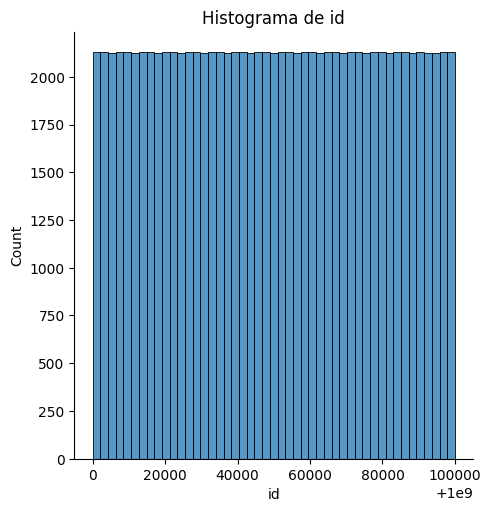

================== Histograma de edad_afiliado ===================
Guardado: histogramas/Histograma_edad_afiliado_DataFrame_1.png


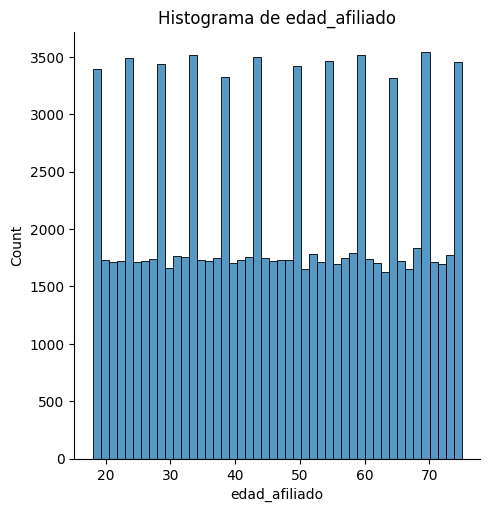

================== Histograma de antiguedad_afiliado_años ===================
Guardado: histogramas/Histograma_antiguedad_afiliado_años_DataFrame_1.png


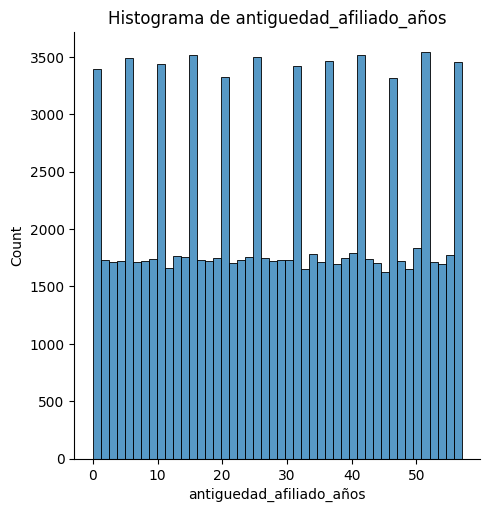

================== Histograma de recaudo_mensual ===================
Guardado: histogramas/Histograma_recaudo_mensual_DataFrame_1.png


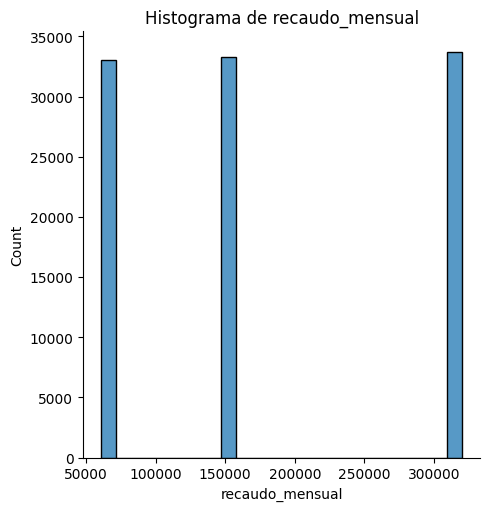

================== Histograma de recaudo_anual ===================
Guardado: histogramas/Histograma_recaudo_anual_DataFrame_1.png


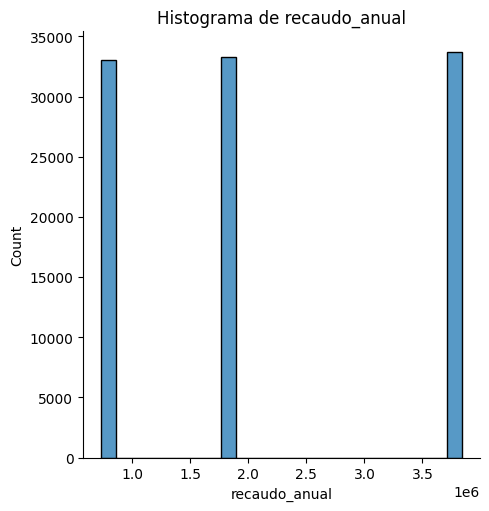

================== Histograma de cantidad_subsidios ===================
Guardado: histogramas/Histograma_cantidad_subsidios_DataFrame_1.png


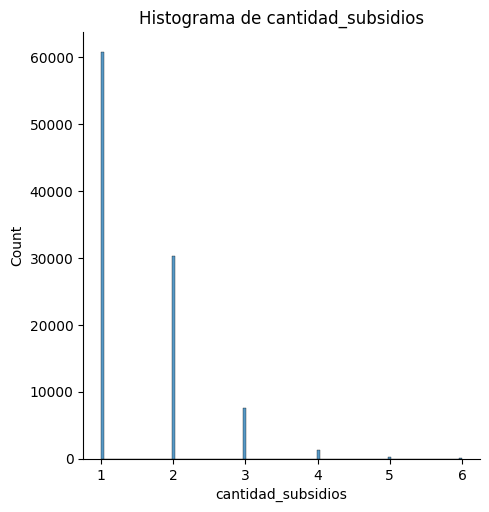

================== Histograma de monto_total_subsidios ===================
Guardado: histogramas/Histograma_monto_total_subsidios_DataFrame_1.png


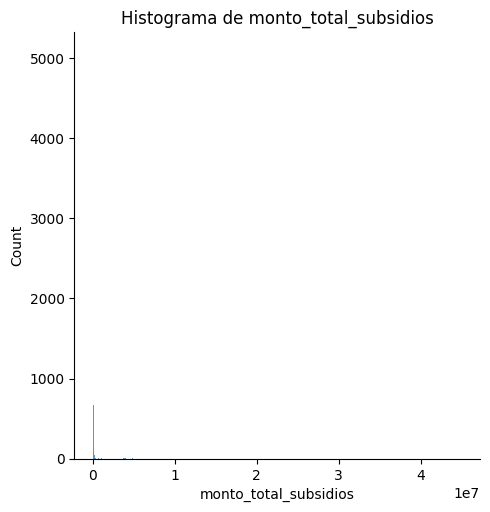

================== Histograma de cantidad_servicios ===================
Guardado: histogramas/Histograma_cantidad_servicios_DataFrame_1.png


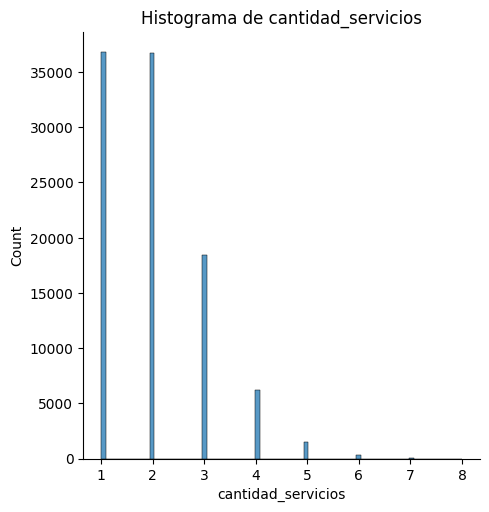

================== Histograma de diversidad_servicios ===================
Guardado: histogramas/Histograma_diversidad_servicios_DataFrame_1.png


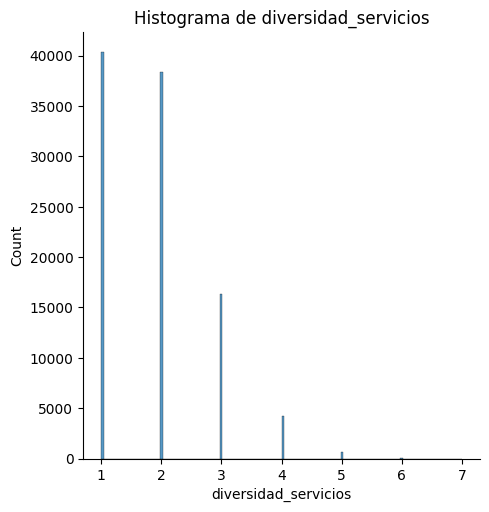

================== Histograma de frecuencia_servicio_dias ===================
Guardado: histogramas/Histograma_frecuencia_servicio_dias_DataFrame_1.png


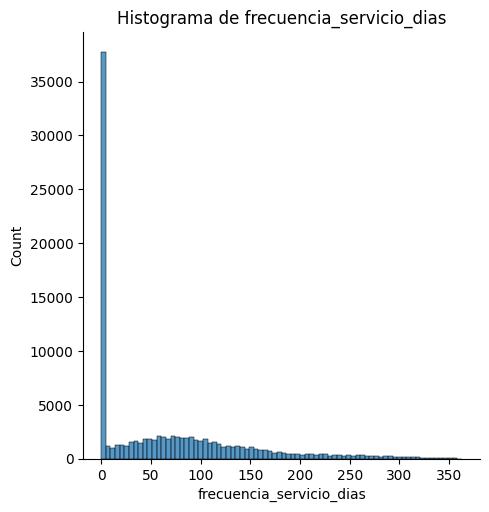

================== Histograma de ha_recibido_subsidio ===================
Guardado: histogramas/Histograma_ha_recibido_subsidio_DataFrame_1.png


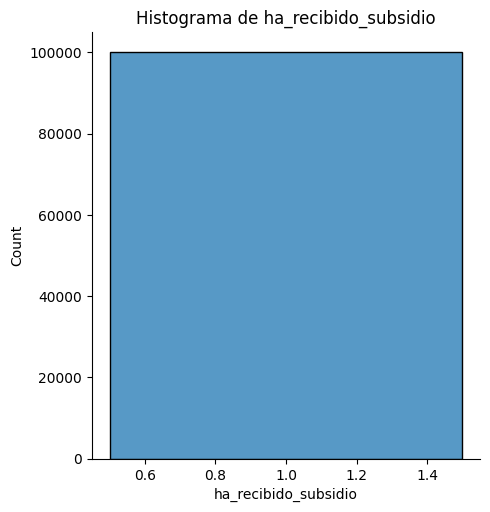

================== Histograma de subsidio_promedio ===================


KeyboardInterrupt: 

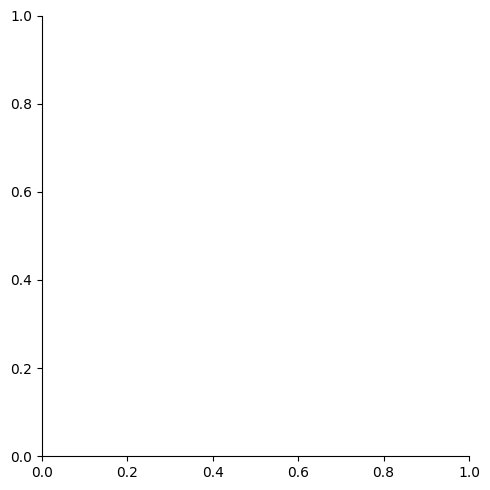

In [59]:
archivos = generar_histogramas_png([usuarios_enriquecido, df_estrategico, tasa_retencion_df, resumen_categoria], output_dir='histogramas')

In [60]:
#================================   Generar Matrices de Correlación

def generar_matrices_correlacion(dataframes, output_dir='matrices_correlacion', save_png=True, cmap='Blues'):
    """
    Genera matrices de correlación para todas las columnas numéricas de una lista de DataFrames.
    Guarda los mapas de calor como PNG.

    Parámetros:
    - dataframes (list): Lista de DataFrames o un solo DataFrame.
    - output_dir (str): Directorio donde se guardarán los archivos PNG. Por defecto, 'matrices_correlacion'.
    - save_png (bool): Si True, guarda las matrices como PNG. Por defecto, True.
    - cmap (str): Mapa de colores de Seaborn para la matriz. Por defecto, 'Blues'.

    Retorna:
    - list: Lista de rutas de los archivos PNG generados.
    """
    # Asegurar que dataframes sea una lista
    if isinstance(dataframes, pd.DataFrame):
        dataframes = [dataframes]

    # Crear directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)

    # Lista para almacenar rutas de archivos generados
    archivos_generados = []

    # Iterar sobre cada DataFrame
    for idx, df in enumerate(dataframes):
        df_name = f"DataFrame_{idx+1}"
        print(f"\n================== Matriz de Correlación para {df_name} ===================")

        # Seleccionar columnas numéricas
        num_cols = df.select_dtypes(include=np.number).columns

        if len(num_cols) < 2:
            print(f"Advertencia: {df_name} tiene menos de 2 columnas numéricas. Saltando...")
            continue

        # Calcular matriz de correlación
        corr_matrix = df[num_cols].corr()
        print(f"\nMatriz de correlación para {df_name}:\n{corr_matrix}")

        # Crear figura
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, vmin=-1, vmax=1, center=0)
        plt.title(f'Matriz de Correlación ({df_name})')

        # Guardar PNG
        if save_png:
            filename = f'Matriz_Correlacion_{df_name}.png'
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath)
            print(f"Guardado: {filepath}")
            archivos_generados.append(filepath)

        # Mostrar gráfico
        plt.show()
        plt.close()

    return archivos_generados

# Ejemplo de uso
# Suponiendo que tienes tres DataFrames: df_subsidios, df_afiliados, df_otros
# archivos = generar_matrices_correlacion([df_subsidios, df_afiliados, df_otros], output_dir='matrices_correlacion', cmap='Blues')


================== Matriz de Correlación para DataFrame_1 ===================

Matriz de correlación para DataFrame_1:
                                     id  edad_afiliado  \
id                             1.000000      -0.000278   
edad_afiliado                 -0.000278       1.000000   
antiguedad_afiliado_años      -0.000278       1.000000   
recaudo_mensual               -0.005813      -0.000441   
recaudo_anual                 -0.005813      -0.000441   
cantidad_subsidios             0.000362      -0.004634   
monto_total_subsidios         -0.000980      -0.002483   
cantidad_servicios            -0.003505      -0.003214   
diversidad_servicios          -0.005407      -0.002111   
frecuencia_servicio_dias      -0.005530      -0.007067   
ha_recibido_subsidio                NaN            NaN   
subsidio_promedio             -0.001458      -0.000006   
dias_desde_ultima_interaccion -0.000944       0.006044   

                               antiguedad_afiliado_años  recaudo_me

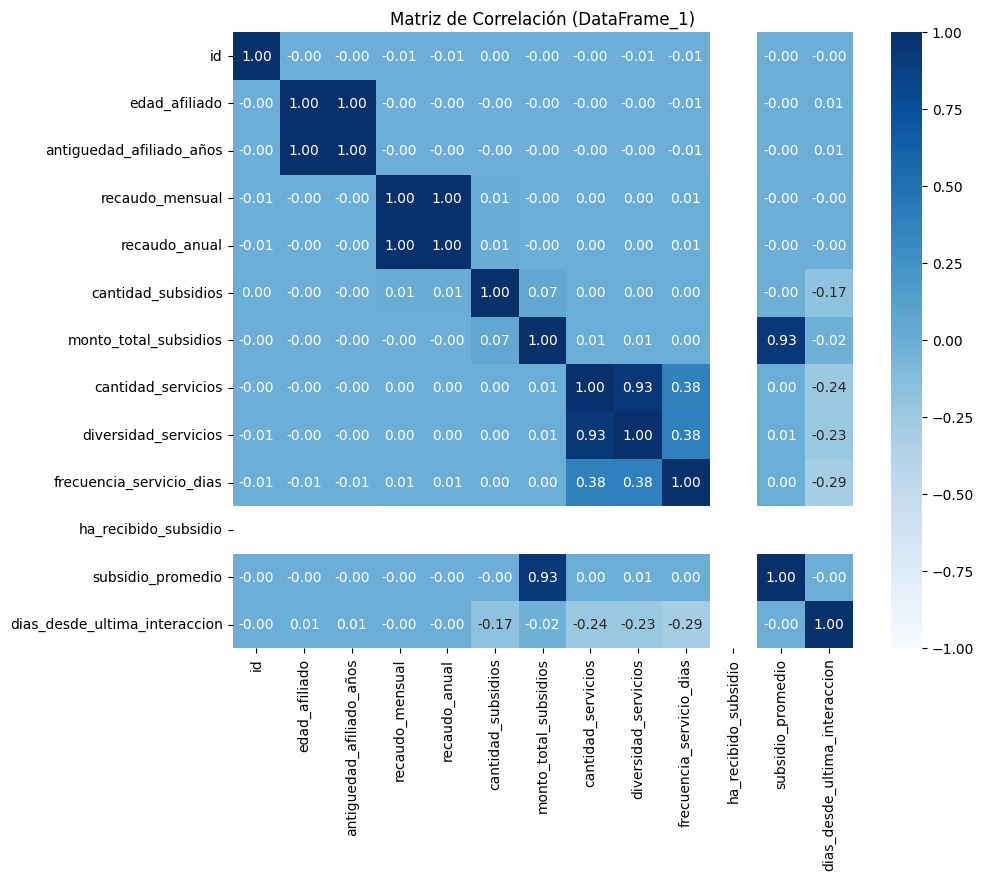


================== Matriz de Correlación para DataFrame_2 ===================

Matriz de correlación para DataFrame_2:
                                     id  edad_afiliado  \
id                             1.000000      -0.000278   
edad_afiliado                 -0.000278       1.000000   
antiguedad_afiliado_años      -0.000278       1.000000   
recaudo_mensual               -0.005813      -0.000441   
recaudo_anual_x               -0.005813      -0.000441   
cantidad_subsidios             0.000362      -0.004634   
monto_total_subsidios         -0.000980      -0.002483   
cantidad_servicios            -0.003505      -0.003214   
diversidad_servicios          -0.005407      -0.002111   
frecuencia_servicio_dias      -0.005530      -0.007067   
ha_recibido_subsidio                NaN            NaN   
subsidio_promedio             -0.001458      -0.000006   
dias_desde_ultima_interaccion -0.000944       0.006044   
recaudo_anual_y               -0.005813      -0.000441   
total_subs

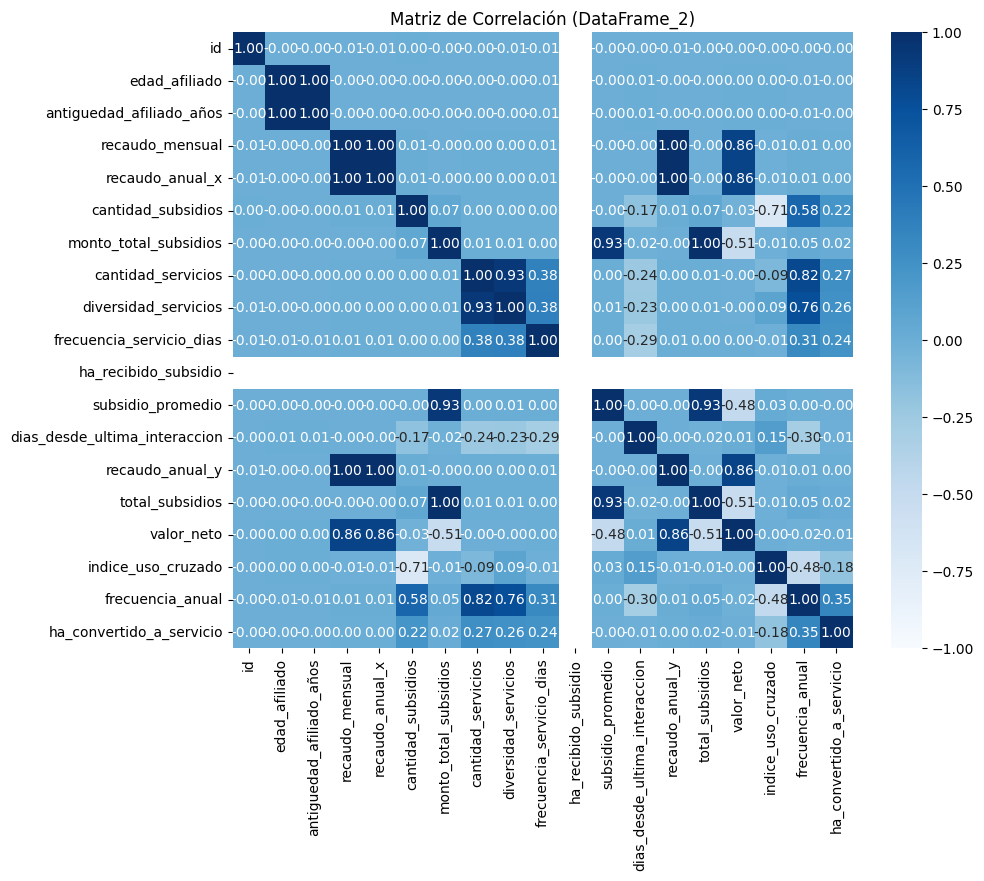


================== Matriz de Correlación para DataFrame_3 ===================

Matriz de correlación para DataFrame_3:
                        usuarios_mes_actual  mes_siguiente_usuarios  \
usuarios_mes_actual                1.000000                0.073865   
mes_siguiente_usuarios             0.073865                1.000000   
tasa_retencion                    -0.167806                0.967968   

                        tasa_retencion  
usuarios_mes_actual          -0.167806  
mes_siguiente_usuarios        0.967968  
tasa_retencion                1.000000  
Guardado: matrices_correalelacion/Matriz_Correlacion_DataFrame_3.png


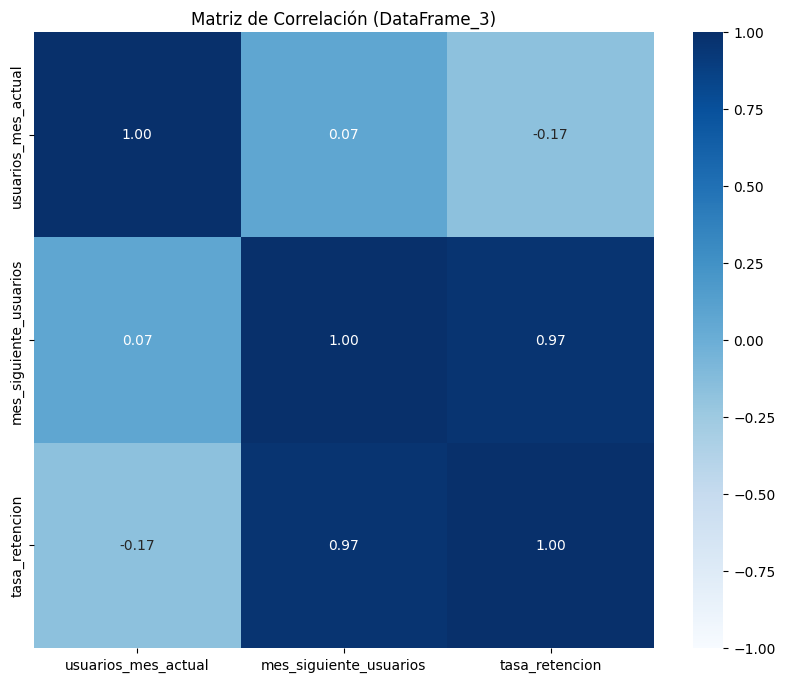


================== Matriz de Correlación para DataFrame_4 ===================

Matriz de correlación para DataFrame_4:
                    valor_neto  indice_uso_cruzado  frecuencia_anual
valor_neto            1.000000           -0.999959          0.964857
indice_uso_cruzado   -0.999959            1.000000         -0.962447
frecuencia_anual      0.964857           -0.962447          1.000000
Guardado: matrices_correalelacion/Matriz_Correlacion_DataFrame_4.png


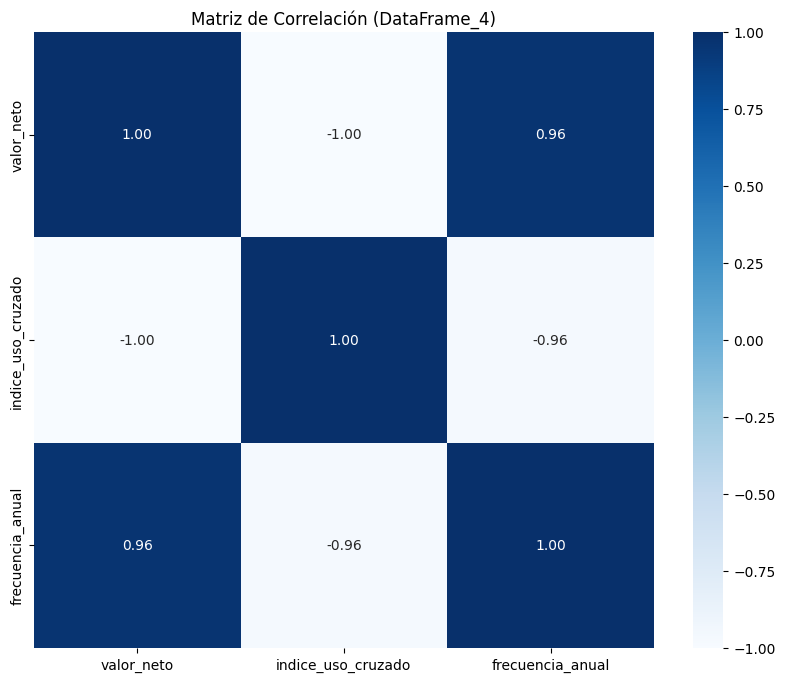

In [61]:
archivos_correlacion= generar_matrices_correlacion([usuarios_enriquecido, df_estrategico, tasa_retencion_df, resumen_categoria], output_dir='matrices_correalelacion', cmap='Blues')

# **Cargar Datasets Transformados y con Nuevas Caracteristicas**


*   Aqui se estaria completando eel pipiline de datos
*   Simularemos la alimentacion de herramientas Bi de analisis semestral o anual.
*   Para ver las herramientas BI Generadas, visita el repositorio.

>>https://github.com/CristhianSeverino/Afiliados360.git




In [32]:
#===========================   Función de Carga de los data sets con ingenieria de caracteristicas   ========================
def upload_to_s3(bucket_name2, files_to_upload2, aws_access_key_id=None, aws_secret_access_key=None, region_name=None):
    # Configurar Cliente S3
    try:
        s3_client = boto3.client(
            's3',
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
            region_name=region_name
        )
    except Exception as e:
        print(f"Error al configurar el cliente S3: {str(e)}...Verifica ;)")
        return []

    uploaded_files = []
    for s3_file_path, local_file_path in files_to_upload2:
        print("="*50)
        print(f"   Subiendo {local_file_path} a {s3_file_path}...")
        print("="*50)

        #Verificar xistencia del Archivo Local. en caso de error. verifica la ejecucion de la session aterior ;)
        if not os.path.exists(local_file_path):
            print(f"Error: el Archivo local {local_file_path} o Existe... VERIFICA PASO ANTERIOR")
            continue
        try:
            s3_client.upload_file(local_file_path, bucket_name2, s3_file_path)
            print(f"Archivo subido con Exito: {s3_file_path} en el bucket {bucket_name2}")
            uploaded_files.append(s3_file_path)
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == 'AccessDenied':
                print(f"Error: Acceso Denegado al intentar subir {s3_file_path} al bucket {bucket_name2}. Verifica las Credenciales y Permisos.")
            else:
                print(f"Error Al Subir el Archivo {local_file_path} a S3: {str(e)}")

        except Exception as e:
            print(f"Error inesperado al subir {local_file_path}: {str(e)}")
    return uploaded_files

In [33]:
#=====================================   Iniciacion de la Función de Carga   ==========================================
if __name__ == "__main__":
    bucket_name2 = "transform-360-afiliados"
    files_to_upload2 = [
        ("FeatureEngineering/usuarios_enriquecidos.csv", "/content/Feature_Engineering/usuarios_enriquecido.csv"),
        ("FeatureEngineering/dataset_estrategico.csv", "/content/Feature_Engineering/df_estrategico.csv"),
        ("FeatureEngineering/resumen_categoria.csv", "/content/Feature_Engineering/resumen_categoria.csv"),
        ("FeatureEngineering/tasa_retencion.csv", "/content/Feature_Engineering/tasa_retencion_df.csv")
    ]

    # Subir Archivo
    uploaded = upload_to_s3(bucket_name2, files_to_upload2)
    if not uploaded:
        print("No se pudieron subir algunos arrchivos...")


   Subiendo /content/Feature_Engineering/usuarios_enriquecido.csv a FeatureEngineering/usuarios_enriquecidos.csv...
Archivo subido con Exito: FeatureEngineering/usuarios_enriquecidos.csv en el bucket transform-360-afiliados
   Subiendo /content/Feature_Engineering/df_estrategico.csv a FeatureEngineering/dataset_estrategico.csv...
Archivo subido con Exito: FeatureEngineering/dataset_estrategico.csv en el bucket transform-360-afiliados
   Subiendo /content/Feature_Engineering/resumen_categoria.csv a FeatureEngineering/resumen_categoria.csv...
Archivo subido con Exito: FeatureEngineering/resumen_categoria.csv en el bucket transform-360-afiliados
   Subiendo /content/Feature_Engineering/tasa_retencion_df.csv a FeatureEngineering/tasa_retencion.csv...
Archivo subido con Exito: FeatureEngineering/tasa_retencion.csv en el bucket transform-360-afiliados
